<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Immune-gene-expression-analysis-in-NBL" data-toc-modified-id="Immune-gene-expression-analysis-in-NBL-1">Immune gene expression analysis in NBL</a></span></li><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-2">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-4">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-5">Main</a></span><ul class="toc-item"><li><span><a href="#Palettes" data-toc-modified-id="Palettes-5.1">Palettes</a></span></li><li><span><a href="#Heatmaps-for-TARGET-NBL" data-toc-modified-id="Heatmaps-for-TARGET-NBL-5.2">Heatmaps for TARGET NBL</a></span><ul class="toc-item"><li><span><a href="#Groups" data-toc-modified-id="Groups-5.2.1">Groups</a></span></li><li><span><a href="#MYCN" data-toc-modified-id="MYCN-5.2.2">MYCN</a></span></li><li><span><a href="#COG-risk" data-toc-modified-id="COG-risk-5.2.3">COG risk</a></span></li><li><span><a href="#clinical-data" data-toc-modified-id="clinical-data-5.2.4">clinical data</a></span></li><li><span><a href="#Immunescore" data-toc-modified-id="Immunescore-5.2.5">Immunescore</a></span></li><li><span><a href="#gene-expression" data-toc-modified-id="gene-expression-5.2.6">gene expression</a></span></li></ul></li><li><span><a href="#KF_NBL-dataset" data-toc-modified-id="KF_NBL-dataset-5.3">KF_NBL dataset</a></span><ul class="toc-item"><li><span><a href="#MYC" data-toc-modified-id="MYC-5.3.1">MYC</a></span></li><li><span><a href="#Gene-expression" data-toc-modified-id="Gene-expression-5.3.2">Gene expression</a></span></li><li><span><a href="#Immunescore" data-toc-modified-id="Immunescore-5.3.3">Immunescore</a></span></li><li><span><a href="#clinical" data-toc-modified-id="clinical-5.3.4">clinical</a></span></li></ul></li></ul></li><li><span><a href="#Related-to-numbers-in-text" data-toc-modified-id="Related-to-numbers-in-text-6">Related to numbers in text</a></span></li></ul></div>

# Immune gene expression analysis in NBL

# Dependencies

In [1]:
library(ggplot2)
library(dplyr)
library(circlize)
library(ggbeeswarm)
library(gridExtra)
library(reshape2)
library(ComplexHeatmap)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

circlize version 0.4.9
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: grid
ComplexHeatmap version 1.99.5
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published r

# Functions

In [2]:
clinical_hm <- function(cohort_vector, estimate_manifest){
    
    clin_matrix <- estimate_manifest[,c("sample_id", "gender",
                                        "race", "age_class")]
    rownames(clin_matrix) <- clin_matrix$sample_id
    clin_matrix$sample_id <- NULL
    clin_matrix_cases <- clin_matrix[rownames(clin_matrix) %in% names(cohort_vector),]
    # This is to match the order in matrix to the cohorts
    clin_matrix_cases <- clin_matrix_cases[names(cohort_vector),]    

    clin_matrix_cases <- as.matrix(clin_matrix_cases)
    ht_clinical = Heatmap(clin_matrix_cases,
                         #titles and names
                         name = "Clinical",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = c(agepal, genderpal, racepal),
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(3, "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)
    return(ht_clinical)
}

In [3]:
immune_hm <- function(cohort_vector, estimate_manifest){

    immune <- estimate_manifest$percread
    names(immune) <- estimate_manifest$sample_id
    immune_cases <- immune[names(immune) %in% names(cohort_vector)]
    # This is to match the order in matrix to the cohorts
    immune_cases <- immune_cases[names(cohort_vector)]    
 
    col_fun_immun = colorRamp2(c(4,30), 
                               c("#ccebc5", "#084081"))   
    
    ht_immune = Heatmap(immune_cases,
                         #titles and names
                         name = "% immune reads",
                         show_row_names = TRUE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = col_fun_immun,
                         column_names_gp = gpar(fontsize = 28),
                         width = unit(1, "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)
    
    
    return(ht_immune)
}

In [4]:
geneset_hm_z <- function(gene_mat, cohort_vector, estimate_manifest, geneset){
  
    message("number of genes in geneset found in matrix:")
    print(length(rownames(gene_mat)[rownames(gene_mat) %in% geneset]) )
    message("genes not found in matrix:")
    print(geneset[!geneset %in% rownames(gene_mat)])    
    #keep only genes found in matrix
    geneset <- geneset[geneset %in% rownames(gene_mat)]
    
    subst_exp <- gene_mat[geneset,]

 
    ## To transpose and order exp data based on geneset
    subst_exp <- t(subst_exp)
    ## z score
    subst_exp_z <- scale(subst_exp)

    subst_exp_cases <- subst_exp_z[rownames(subst_exp_z) %in% names(cohort_vector),]
    # This is to match the order in matrix to the cohorts
    subst_exp_cases <- subst_exp_cases[names(cohort_vector),]
    subst_exp_cases <- as.matrix(subst_exp_cases)
    gene_hm = Heatmap(subst_exp_cases,
                         #titles and names   
                      name = "Gene (z-score)",   
                      show_row_names = FALSE,
                      show_column_names = TRUE,     
                      #clusters and orders  
                      cluster_columns = FALSE,
                      cluster_rows = TRUE,
                      show_column_dend = TRUE,
                      row_dend_width = unit(8, "cm"),
                      column_order = geneset, 
                      #aesthestics
                      # col = col_fun_genes,
                      column_names_gp = gpar(fontsize = 28),
                      row_names_gp = gpar(fontsize = 2),
                      width = unit(length(geneset), "cm"),
                      column_title_gp = gpar(fontsize = 42),
                      column_title = NULL,
                      row_title = NULL
)

    return(gene_hm)
}

In [5]:
geneset_hm <- function(gene_mat, cohort_vector, estimate_manifest, geneset){
    subst_exp <- gene_mat[which(rownames(gene_mat) %in% geneset),]
   
    ## To order exp data based on geneset
    subst_exp <- subst_exp[geneset,]
    subst_exp <- log2(subst_exp + 1)   

    subst_exp_cases <- subst_exp[, colnames(subst_exp) %in% names(cohort_vector)]
    # This is to match the order in matrix to the cohorts
    subst_exp_cases <- subst_exp_cases[,names(cohort_vector)]
    subst_exp_cases <- as.matrix(subst_exp_cases)
    gene_hm = Heatmap(t(subst_exp_cases),
                         #titles and names   
                      name = "Gene expression (log2)",   
                      show_row_names = FALSE,
                      show_column_names = TRUE,     
                      #clusters and orders  
                      cluster_columns = FALSE,
                      cluster_rows = TRUE,
                      show_column_dend = FALSE,
                      row_dend_width = unit(8, "cm"),
                      column_order = geneset, 
                      #aesthestics
                      # col = col_fun_genes,
                      column_names_gp = gpar(fontsize = 28),
                      row_names_gp = gpar(fontsize = 2),
                      width = unit(length(geneset), "cm"),
                      column_title_gp = gpar(fontsize = 42),
                      column_title = NULL,
                      row_title = NULL
)

    return(gene_hm)
}

# Paths

In [6]:
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Manifests/"
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

In [7]:
load(paste0(datapath,"exp_mat/tpm_matrix_ped_final.RData"))

In [8]:
dim(tpm_matrix_ped_final)

[1] 30594  1177

In [9]:
load(file = paste0(datapath, "ESTIMATE/estimate_manifest_primary_clean_final.RData"))

In [10]:
estimate_manifest_primary_clean$percread <- 8.0947988*exp(estimate_manifest_primary_clean$ImmuneScore*0.0006267)

In [11]:
table(estimate_manifest_primary_clean$group)


 CBTTC   DKFZ KF_NBL   PNOC TARGET   TCGA 
   591    196    209     32    149   2452 

Cut at -1000 Immunescore subset to NBL

In [12]:
estimate_manifest_primary_cutoff <- estimate_manifest_primary_clean[estimate_manifest_primary_clean$ImmuneScore > -1000,]

In [13]:
NBL <- estimate_manifest_primary_cutoff[estimate_manifest_primary_cutoff$cohort == "NBL",]
NBL <- NBL[NBL$group == "TARGET",]

In [14]:
table(NBL$group)


TARGET 
   122 

In [15]:
head(NBL)

aliquot_id,StromalScore,ImmuneScore,ESTIMATEScore,name,case_id,sample_id,gender,ethnicity,race,⋯,days_to_death,days_to_progress,recurrence,disease_type,primary_site,group,cohort,sample_type,age_class,percread
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
TARGET-30-PAIFXV-01A-01R,-537.97880,483.8556,-54.1232,af82838c-9071-4dd7-8766-b818cf61cf82.bam,TARGET-30-PAIFXV,TARGET-30-PAIFXV-01A,Female,Unknown,White,⋯,2075,1675,Yes,Neuroblastoma,Abdomen,TARGET,NBL,Primary Tumor,Children,10.962211
TARGET-30-PAIPGU-01A-01R,-319.22630,1240.6492,921.4229,b1d954e7-21a0-441e-a9c7-47e6a6454625.bam,TARGET-30-PAIPGU,TARGET-30-PAIPGU-01A,Female,Unknown,White,⋯,1976,1976,No,Neuroblastoma,Adrenal gland,TARGET,NBL,Primary Tumor,NA,17.614749
TARGET-30-PAISNS-01A-01R,-899.30090,-128.2337,-1027.5347,7e145f1d-1807-4615-95b5-2684ccbcb348.bam,TARGET-30-PAISNS,TARGET-30-PAISNS-01A,Male,Unknown,White,⋯,2829,2829,No,Neuroblastoma,Abdomen,TARGET,NBL,Primary Tumor,NA,7.469721
TARGET-30-PAITCI-01A-01R,-327.26820,200.6735,-126.5947,9704403e-aaf9-4a97-99bc-b2a9a9861767.bam,TARGET-30-PAITCI,TARGET-30-PAITCI-01A,Male,Unknown,White,⋯,333,201,Yes,Neuroblastoma,Adrenal gland,TARGET,NBL,Primary Tumor,Infants,9.179602
TARGET-30-PAIVHE-01A-01R,-15.87499,1033.6469,1017.7719,d8d30bd7-608d-4cbd-ba31-3f1fa6fefacf.bam,TARGET-30-PAIVHE,TARGET-30-PAIVHE-01A,Male,not hispanic or latino,White,⋯,768,709,Yes,"Ganglioneuroblastoma, nodular",Adrenal gland,TARGET,NBL,Primary Tumor,Children,15.471633
TARGET-30-PAIXIF-01A-01R,460.15050,978.1672,1438.3177,7c2b0108-1231-4543-a8bf-eb6644e76f41.bam,TARGET-30-PAIXIF,TARGET-30-PAIXIF-01A,Male,Unknown,Unknown,⋯,3122,302,Yes,Neuroblastoma,Retroperitoneum,TARGET,NBL,Primary Tumor,Children,14.942943


Get MYCN status and COG risk groups

In [16]:
NBL_manifest <- read.table(paste0(manifestpath, "TARGET_NBL_Discovery_ClinicalData_20170525.txt"),
                          sep = "\t", na.strings = "", header = T, stringsAsFactors = F)

In [17]:
colnames(NBL_manifest)[colnames(NBL_manifest) == "TARGET.USI"] <- "case_id"

In [18]:
NBL_manifest_subset <- NBL_manifest[NBL_manifest$case_id %in% NBL$case_id,]

In [19]:
dim(NBL_manifest_subset)

[1] 122  32

In [20]:
NBL_MYCstatus <- merge(NBL, NBL_manifest_subset[, c("case_id", "MYCN.status", "COG.Risk.Group")], by = "case_id")

In [21]:
dim(NBL_MYCstatus)

[1] 122  24

## Palettes

In [22]:
cogpal <- c("High Risk" = "#6a3d9a",
            "Intermediate Risk" = "#a6cee3",
            "Low Risk" = "#fb9a99")

In [23]:
mycnpal <- c("Amplified" = "#e41a1c",
            "Not Amplified" = "#377eb8",
            "Unknown" = "light grey")

In [27]:
grouppal <- c("TARGET" = "#678ba5",
             "CBTTC" = "#e31a1c",
             "KF_NBL" = "#8763ae")

In [28]:
colpal <- c("MB_PDX" = "#878787", #PDX
            "ETMR" = "#76afa9", #ped
            "MNG" = "#a6cee3", 
            "MB" =  "#1f78b4",
            "SCHW" =  "#678ba5",
            "ATRT" =  "#33a02c",
            "EPN" = "#e31a1c",
            "pedHGG" = "#fdbf6f",
            "pedLGG" = "#8763ae",
            "NFB" = "#cab2d6",
            "CPH" = "#cccc7a",
            "TT/GN" = "#b15928",
            "CP" = "#a9a9a9",
            "NBL" = "#b2df8a",
            "EWS" = "#C65370",
            
            "SKCM" = "#7c9c60", #Adult
            "LGG" = "#753a00",
            "GBM" = "#6a3d9a",
            "OV" = "#afaf78",
            "PRAD" = "#a85426",
            "LUAD" = "#ad3837",
            "COAD" = "#726579",
            "EMPTY" = "#FFFFFF")

Clinical df for clinical heatmap

In [29]:
clin4hm <- NBL[,c("name", "sample_id","gender",
                  "race", "age_at_diagnosis", "age_class",
                  "ImmuneScore","cohort", "group")]

Make a order_vector to order heatmap

In [30]:
NBL_groups <- factor(clin4hm$group, levels =  'TARGET')
names(NBL_groups) <- clin4hm$sample_id
NBL_groups <- NBL_groups[order(NBL_groups)]

## Heatmaps for TARGET NBL

### Groups

In [31]:
ht_groups = Heatmap(NBL_groups,
                         #titles and names
                         name = "Group",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = grouppal,
                         na_col = "#ffffff",
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(length(levels(NBL_groups)), "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)

### MYCN

In [32]:
table(NBL_MYCstatus$MYCN.status)


    Amplified Not Amplified       Unknown 
           17           104             1 

In [33]:
mycnstatus <- factor(NBL_MYCstatus$MYCN.status, levels =  c("Amplified", "Not Amplified", "Unknown"))
names(mycnstatus) <- NBL_MYCstatus$sample_id
mycnstatus <- mycnstatus[names(NBL_groups)]
    
ht_mycn = Heatmap(mycnstatus,
                         #titles and names
                         name = "MYCN status",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = mycnpal,
                         na_col = "#ffffff",
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(length(levels(NBL_groups)), "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)

### COG risk

In [34]:
table(NBL_MYCstatus$COG.Risk.Group)


        High Risk Intermediate Risk          Low Risk 
              102                10                10 

In [35]:
cogrisk <- factor(NBL_MYCstatus$COG.Risk.Group, levels =  c("High Risk", "Intermediate Risk", "Low Risk"))
names(cogrisk) <- NBL_MYCstatus$sample_id
cogrisk <- cogrisk[names(NBL_groups)]
    
ht_cog = Heatmap(cogrisk,
                         #titles and names
                         name = "COG risk group",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = cogpal,
                         na_col = "#ffffff",
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(length(levels(NBL_groups)), "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)


### clinical data

In [46]:
clinical_NBL <- clinical_hm(NBL_groups, NBL)

### Immunescore

In [47]:
immune_NBL <- immune_hm(NBL_groups, NBL)

### gene expression

In [48]:
mygensig <- c("HAVCR2", "LAG3","PDCD1", "CTLA4","TIGIT")

In [49]:
geneset_NBL <- geneset_hm(tpm_matrix_ped_final,  NBL_groups, NBL, mygensig)

In [50]:
hm <- geneset_NBL + immune_NBL + ht_mycn + ht_cog + clinical_NBL

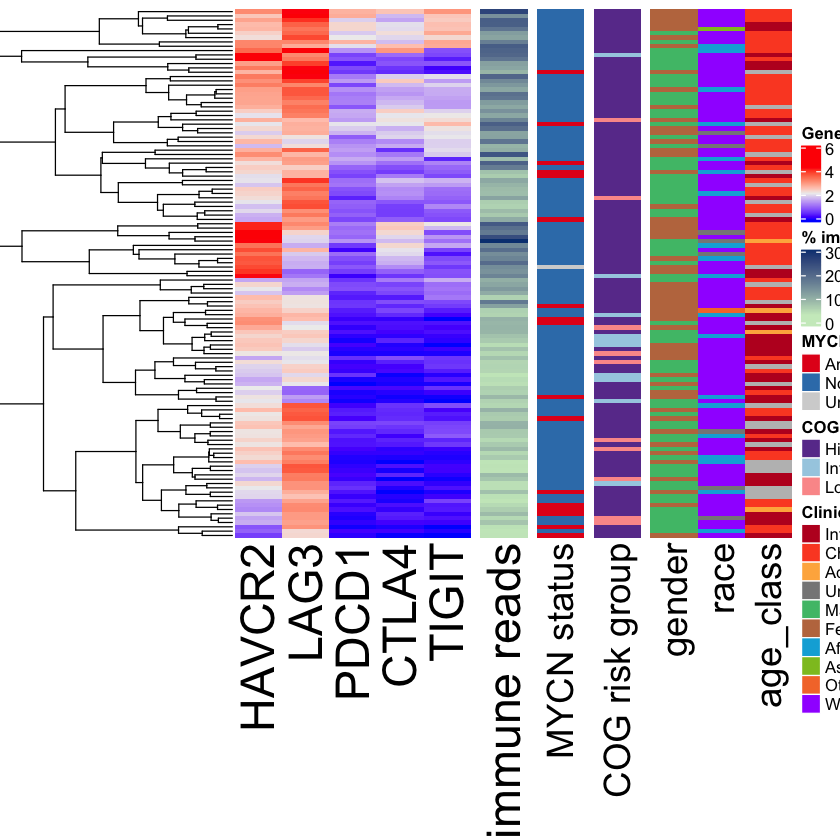

In [51]:
hm

In [44]:
pdf(file = paste0(plotpath,"checkpoint_heatmap_TARGET_NBL.pdf"),
        width = 18, 
        height = 15,
        useDingbats = FALSE)
    draw(hm,
         ht_gap = unit(1, "cm"),
         padding = unit(c(10, 10, 2, 10), "mm"))
    dev.off()


pdf 
  2

## KF_NBL dataset

### MYC

46 samples mycn amp according to pedcbio

In [52]:
mycn_kf <- c(
"GMKF-30-PASCDX03-01B-99R",
"GMKF-30-PASCWD03-01B-99R",
"GMKF-30-PASFKX03-01B-99R",
"GMKF-30-PASFNY03-01B-99R",
"GMKF-30-PASHEL03-01B-99R",
"GMKF-30-PASIIU03-01B-99R",
"GMKF-30-PASIUJ03-01B-99R",
"GMKF-30-PASJRT03-01B-99R",
"GMKF-30-PASKIS03-01B-99R",
"GMKF-30-PASMET03-01B-99R",
"GMKF-30-PASNUI03-01B-99R",
"GMKF-30-PASPGB03-01B-99R",
"GMKF-30-PASREV03-01B-99R",
"GMKF-30-PASUMG03-01B-99R",
"GMKF-30-PASUTC03-01B-99R",
"GMKF-30-PASWXG03-01B-99R",
"GMKF-30-PASWYR03-01B-99R",
"GMKF-30-PASXIE03-01B-99R",
"GMKF-30-PASXRG03-01B-99R",
"GMKF-30-PASXSJ03-01B-99R",
"GMKF-30-PASYIP03-01B-99R",
"GMKF-30-PASZYY03-01B-99R",
"GMKF-30-PATIYD03-01B-99R",
"GMKF-30-PATKPD03-01B-99R",
"GMKF-30-PATMZJ03-01B-99R",
"GMKF-30-PATNZJ03-01B-99R",
"GMKF-30-PATRVB03-01B-99R",
"GMKF-30-PATSVA03-01B-99R",
"GMKF-30-PATTPC03-01B-99R",
"GMKF-30-PATWED03-01B-99R",
"GMKF-30-PATWGR03-01B-99R",
"GMKF-30-PATXKG03-01B-99R",
"GMKF-30-PATYAU03-01B-99R",
"GMKF-30-PATZRF03-01B-99R",
"GMKF-30-PAUGJI03-01B-99R",
"GMKF-30-PAUHSJ03-01B-99R",
"GMKF-30-PAUIHH03-01B-99R",
"GMKF-30-PAUJRW03-01B-99R",
"GMKF-30-PAUKLK03-01B-99R",
"GMKF-30-PAUMJN03-01B-99R",
"GMKF-30-PAUNTY03-01B-99R",
"GMKF-30-PAUTFT03-01B-99R",
"GMKF-30-PAUTLP03-01B-99R",
"GMKF-30-PAUUHH03-01B-99R",
"GMKF-30-PAUUHY03-01B-99R",
"GMKF-30-PAVFZW03-01B-99R")

In [61]:
NBL <- estimate_manifest_primary_cutoff[estimate_manifest_primary_cutoff$cohort == "NBL",]
NBL_KF <- NBL[NBL$group == "KF_NBL",]

In [62]:
table(NBL_KF$group)


KF_NBL 
   163 

In [63]:
NBL_KF_groups <- factor(NBL_KF$group, levels =  'KF_NBL')
names(NBL_KF_groups) <- NBL_KF$sample_id
NBL_KF_groups <- NBL_KF_groups[order(NBL_KF_groups)]

In [64]:
NBL_KF$MYCN.status <- NA
NBL_KF$MYCN.status[ NBL_KF$sample_id %in% mycn_kf] <- "Amplified"
NBL_KF$MYCN.status[!NBL_KF$sample_id %in% mycn_kf] <- "Not Amplified"

In [65]:
table(NBL_KF$MYCN.status)


    Amplified Not Amplified 
           11           152 

In [66]:
mycnstatus_kf <- factor(NBL_KF$MYCN.status, levels =  c("Amplified", "Not Amplified"))
names(mycnstatus_kf) <- NBL_KF$sample_id
mycnstatus_kf <- mycnstatus_kf[names(NBL_KF_groups)]
    
ht_mycn_kf = Heatmap(mycnstatus_kf,
                         #titles and names
                         name = "MYCN status",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = mycnpal,
                         na_col = "#ffffff",
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(length(levels(NBL_groups)), "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)

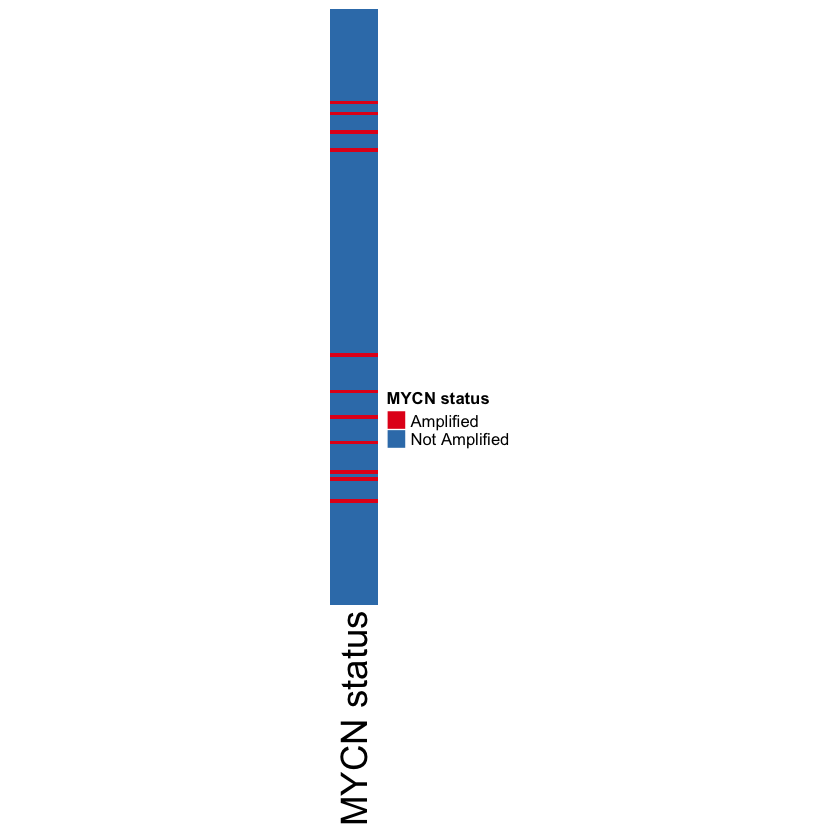

In [67]:
ht_mycn_kf

### Gene expression

In [68]:
geneset_hm_KF <- function(gene_mat, cohort_vector, estimate_manifest, geneset){
    subst_exp <- gene_mat[which(rownames(gene_mat) %in% geneset),]
   
    ## To order exp data based on geneset
    subst_exp <- subst_exp[geneset,]
    subst_exp <- log2(subst_exp + 1)   

    subst_exp_cases <- subst_exp[, colnames(subst_exp) %in% names(cohort_vector)]
    # This is to match the order in matrix to the cohorts
    subst_exp_cases <- subst_exp_cases[,names(cohort_vector)]
    subst_exp_cases <- as.matrix(subst_exp_cases)
    gene_hm = Heatmap(t(subst_exp_cases),
                         #titles and names   
                      name = "Gene expression (log2)",   
                      show_row_names = TRUE,
                      show_column_names = TRUE,     
                      #clusters and orders  
                      cluster_columns = FALSE,
                      cluster_rows = TRUE,
                      show_column_dend = FALSE,
                      row_dend_width = unit(8, "cm"),
                      column_order = geneset, 
                      #aesthestics
                      # col = col_fun_genes,
                      column_names_gp = gpar(fontsize = 28),
                      row_names_gp = gpar(fontsize = 2),
                      width = unit(length(geneset), "cm"),
                      column_title_gp = gpar(fontsize = 42),
                      column_title = NULL,
                      row_title = NULL
)

    return(gene_hm)
}

In [69]:
mygensig <- c("HAVCR2", "LAG3","PDCD1", "CTLA4","TIGIT")

In [70]:
geneset_KF_NBL <- geneset_hm(tpm_matrix_ped_final,  NBL_KF_groups, NBL_KF, mygensig)

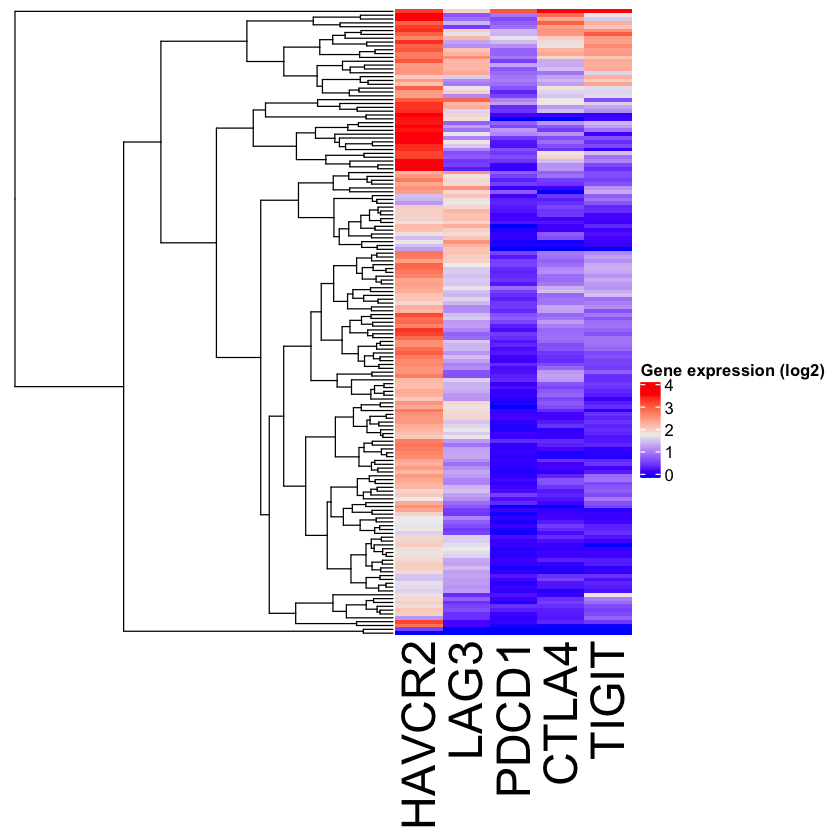

In [71]:
geneset_KF_NBL

### Immunescore

In [72]:
immune_KF <- NBL_KF$percread
names(immune_KF) <- NBL_KF$sample_id
immune_cases_KF <- immune_KF[names(immune_KF) %in% names(NBL_KF_groups)]
    # This is to match the order in matrix to the cohorts
immune_cases_KF <- immune_cases_KF[names(NBL_KF_groups)]    
 
col_fun_immun = colorRamp2(c(4,30), 
                           c("#ccebc5", "#084081"))   
    
ht_immune_KF = Heatmap(immune_cases_KF,
                         #titles and names
                         name = "% immune reads",
                         show_row_names = TRUE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = col_fun_immun,
                         column_names_gp = gpar(fontsize = 28),
                         width = unit(1, "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)

### clinical

manifest file is from kids first drc as of sep 12 2020

In [73]:
KFNBL_manifest <- read.table(paste0(manifestpath, "clinicalDataFileRepo_KF_NBL.txt"),
                          sep = "\t", na.strings = "", header = T, stringsAsFactors = F)

In [74]:
head(KFNBL_manifest)

Participant.ID,External.Id,Family.Id,Proband,Study,Family.Composition,Diagnosis.Category,Gender,Race,Ethnicity,Vital.Status,Age.at.the.Last.Vital.Status..Days.,Is.Outcome.Disease.Related,Affected.Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<lgl>
PT_1X9YQF9W,GMKF-30-PASMUB03,FM_04BZFE4G,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,White,Reported Unknown,Alive,2925,NA,NA
PT_MK375DCF,GMKF-30-PARYAG03,FM_0FKGXBZB,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,White,Not Hispanic or Latino,Alive,2366,NA,NA
PT_XDPN4357,GMKF-30-PASFXC03,FM_0NTB2D12,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,Black or African American,Not Hispanic or Latino,Alive,3005,NA,NA
PT_K5709E5B,GMKF-30-PAUNTY03,FM_0S71PRSG,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,Asian,Not Hispanic or Latino,Deceased,1423,NA,NA
PT_4FTZAAC4,GMKF-30-PATLSY03,FM_10V2K6AD,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,White,Not Hispanic or Latino,Alive,4235,NA,NA
PT_BZZY1BM4,GMKF-30-PASEWZ03,FM_11H8JVMW,Yes,Kids First: Neuroblastoma,trio,Cancer,Male,White,Not Hispanic or Latino,Alive,3320,NA,NA


clean up external id to match case id in NBL_KF

In [75]:
KFNBL_manifest$case_id <- gsub("GMKF-30-", "",KFNBL_manifest$External.Id)

delete gender and race from NBL_KF, merge with the KDNBL manifest to fill them

In [76]:
NBL_KF$race <- NULL
NBL_KF$gender <- NULL

In [77]:
NBL_KF_clinical <- merge(NBL_KF, KFNBL_manifest[,c("case_id", "Gender", "Race")], by = "case_id")

In [78]:
colnames(NBL_KF_clinical)[colnames(NBL_KF_clinical) == "Race"] <- "race"
colnames(NBL_KF_clinical)[colnames(NBL_KF_clinical) == "Gender"] <- "gender"

In [79]:
NBL_KF_clinical$race[NBL_KF_clinical$race == ""] <- NA
NBL_KF_clinical$race[grepl("African",NBL_KF_clinical$race, ignore.case = T)] <- "African"
NBL_KF_clinical$race[grepl("Asian",NBL_KF_clinical$race, ignore.case = T)] <- "Asian"
NBL_KF_clinical$race[grepl("reported",NBL_KF_clinical$race, ignore.case = T)] <- "Unknown"
NBL_KF_clinical$race[grepl("Alaska",NBL_KF_clinical$race, ignore.case = T)] <- "Other"
NBL_KF_clinical$race[grepl("Other",NBL_KF_clinical$race, ignore.case = T)] <- "Other"
NBL_KF_clinical$race[grepl("Pacific",NBL_KF_clinical$race, ignore.case = T)] <- "Other"
NBL_KF_clinical$race[grepl("white",NBL_KF_clinical$race)] <- "White"

In [80]:
table(NBL_KF_clinical$race)


African   Asian   Other Unknown   White 
      9       4       2       9     139 

In [81]:
clin_matrix_KF <- NBL_KF_clinical[,c("sample_id", "gender", "race", "age_class")]
    rownames(clin_matrix_KF) <- clin_matrix_KF$sample_id
    clin_matrix_KF$sample_id <- NULL
    clin_matrix_KF_cases <- clin_matrix_KF[rownames(clin_matrix_KF) %in% names(NBL_KF_groups),]
    # This is to match the order in matrix to the cohorts
    clin_matrix_KF_cases <- clin_matrix_KF_cases[names(NBL_KF_groups),]    

    clin_matrix_KF_cases <- as.matrix(clin_matrix_KF_cases)
    ht_clinical_KF = Heatmap(clin_matrix_KF_cases,
                         #titles and names
                         name = "Clinical",
                         show_row_names = FALSE,
                         show_column_names = TRUE,    
                         #clusters
                         cluster_columns = FALSE,
                         cluster_rows = FALSE,
                         #aesthestics
                         col = c(agepal, genderpal, racepal),
                         column_names_gp = gpar(fontsize = 22),
                         width = unit(3, "cm"),
                         column_title_gp = gpar(fontsize = 42),
                         row_title = NULL)


In [82]:
hm_KF <- geneset_KF_NBL + ht_immune_KF + ht_mycn_kf + ht_mycn_kf + ht_clinical_KF

Warning message:
“Heatmap/annotation names are duplicated: MYCN status”Warning message:
“Heatmap/annotation names are duplicated: MYCN status”

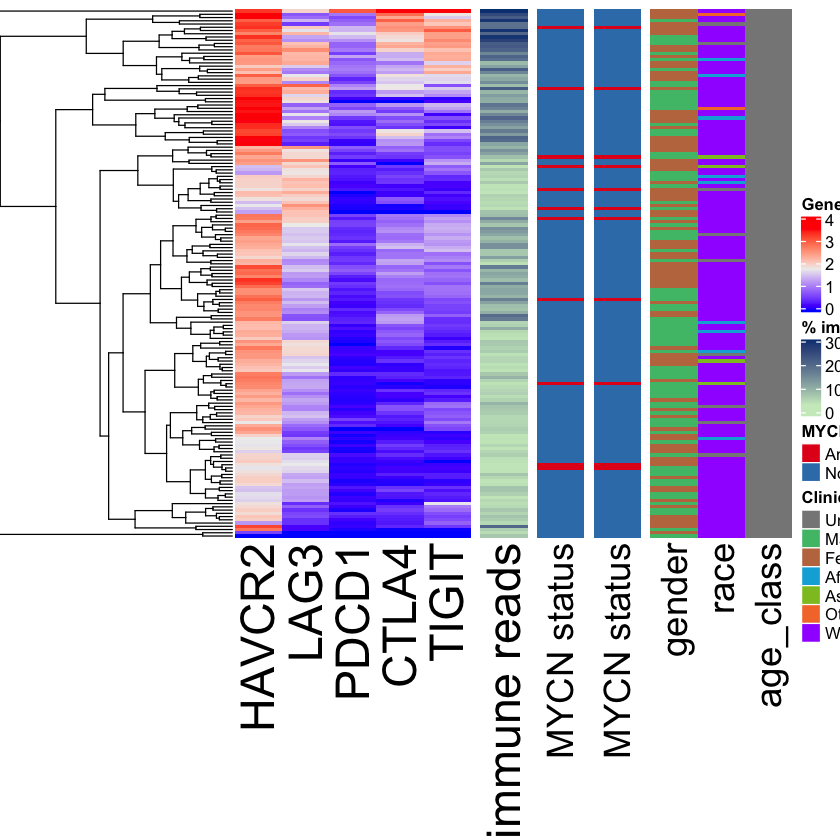

In [83]:
hm_KF

In [92]:
pdf(file = paste0(plotpath,"checkpoint_heatmap_KF_NBL.pdf"),
        width = 18, 
        height = 15,
        useDingbats = FALSE)
    draw(hm_KF,
         ht_gap = unit(1, "cm"),
         padding = unit(c(10, 10, 2, 10), "mm"))
    dev.off()

pdf 
  2

# Related to numbers in text

In [18]:
TARGETids_highTIM3 <- c(
"TARGET-30-PANGXK-01A",
"TARGET-30-PAUDDK-01A",
"TARGET-30-PALCBW-01A",
"TARGET-30-PAPTCR-01A",
"TARGET-30-PANSBN-01A",
"TARGET-30-PATEKG-01A",
"TARGET-30-PASGAP-01A",
"TARGET-30-PANXJL-01A",
"TARGET-30-PANKFE-01A",
"TARGET-30-PAIXIF-01A",
"TARGET-30-PASMJG-01A",
"TARGET-30-PARSBI-01A",
"TARGET-30-PALVKK-01A")

In [19]:
head(tpm_matrix_ped_final)

,7316-1926,7316-489,7316-13,7316-3936,7316-873,7316-2669,7316-1928,7316-1655,7316-2622,7316-2893,⋯,ICGC_PA89,ICGC_PA9,ICGC_PA91,ICGC_PA92,ICGC_PA93,ICGC_PA94,ICGC_PA95,ICGC_PA96,ICGC_PA97,ICGC_PA99
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK,101.08,113.29,143.37,167.31,222.65,133.89,114.69,95.22,8.11,96.12,⋯,0.287477450,1.510045e-01,1.316372799,0.623302011,5.390079e-01,0.2323849,0.00000000,0.62421705,0.204103009,0.27949627
A1BG,0.82,3.00,2.33,2.07,3.87,0.60,1.64,1.01,3.29,0.92,⋯,0.730796870,5.787472e-01,1.432226226,1.305533013,1.757023e+00,0.6259475,0.66270817,0.95084569,0.856170521,0.90799219
A1BG-AS1,0.34,1.54,0.66,1.74,2.21,0.10,0.49,0.33,0.24,0.34,⋯,0.146521078,1.951477e-01,0.359481416,0.459126757,2.827870e-01,0.4634999,0.18452624,0.49039428,0.170731858,0.18425727
A1CF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,⋯,0.003605546,5.714179e-03,0.003864498,0.008657391,7.485289e-03,0.0099566,0.01394094,0.01546211,0.007234758,0.01149084
A2M,270.92,22.46,58.90,40.02,39.74,52.95,34.72,4.87,11.78,34.41,⋯,35.557882596,1.358033e+02,63.220854602,63.728948340,1.480167e+02,79.4678037,97.16209388,64.46924760,71.294566832,120.79589095
A2M-AS1,0.38,0.21,0.23,0.43,0.35,0.38,0.98,0.14,0.05,0.33,⋯,0.744254574,4.421134e-01,0.197240583,0.916434869,1.896832e-01,0.7646672,0.21666408,0.50357142,0.318341732,0.40298729


In [20]:
tim3 <- tpm_matrix_ped_final["HAVCR2", TARGETids_highTIM3]

In [21]:
summary(unlist(tim3))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.50   12.04   14.54   15.06   17.41   26.17 

In [22]:
KFids_highTIM3 <- c(
"GMKF-30-PASKZT03-01B-99R",
"GMKF-30-PAUIRD03-01B-99R",
"GMKF-30-PAUTFT03-01B-99R",
"GMKF-30-PATLBP03-01B-99R",
"GMKF-30-PAUYFR03-01B-99R",
"GMKF-30-PASKFM03-01B-99R",
"GMKF-30-PATLDR03-01B-99R",
"GMKF-30-PATJDG03-01B-99R",
"GMKF-30-PAUPMU03-01B-99R",
"GMKF-30-PATBCM03-01B-99R",
"GMKF-30-PATSUL03-01B-99R",
"GMKF-30-PAUKYI03-01B-99R",
"GMKF-30-PASCGM03-01B-99R",
"GMKF-30-PASUMK03-01B-99R",
"GMKF-30-PARWEV03-01B-99R",
"GMKF-30-PARZCJ03-01B-99R",
"GMKF-30-PASXWF03-01B-99R",
"GMKF-30-PASYYZ03-01B-99R",
"GMKF-30-PARYAG03-01B-99R")

In [23]:
tim3_KF <- tpm_matrix_ped_final["HAVCR2", KFids_highTIM3]

In [24]:
summary(unlist(tim3_KF))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.750   8.835   9.740  10.228  10.580  16.810 

In [25]:
dim(tpm_matrix_ped_final)

[1] 30594  1177

In [29]:
nbl_tpm <- tpm_matrix_ped_final[,colnames(tpm_matrix_ped_final) %in% NBL$sample_id]

In [31]:
summary(unlist(nbl_tpm["HAVCR2",]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.680   3.175   4.380   5.800   6.372  26.170 